# Shakespeare Misattribution Investigation

Author: Drew Holcombe

## Overview

The authorship of plays written during the Elizabethan period is poorly documented: uncredited collaborations were common, and publishers frequently misattributed work to the incorrect writer. As such, plays credited to Shakespeare were not always exclusively written by him: some may have been collaborations, or may have been revised by other writers. Using the text of plays known to have been written by Shakespeare and one of his contemporaries, Thomas Middleton, can one identify instances of potential collaboration using natural language processing?

## Business Problem

Plays written during Shakespeare's time, the Elizabethan period, are rarely documented clearly. Writing plays during this time looked more like writing films does today that it looks like writing novels or plays. It was common for writers to collaborate or revise others' work, and this was not always credited; for example, Shakespeare is known to have written works with John Fletcher, Thomas Middleton, and George Wilkins, both in some instances that were documented at the time and some when they were not. Historians and literary scholars have identified uncredited collaborations in the past based on writing style, handwriting, and other factors.

One play credited to Shakespeare that has been widely speculated, but never proven, to have been a collaboration is Timon of Athens. Many aspects of this play are unusual for Shakespeare: its writing style changes throughout the play, its tone is unusually cynical, and its conclusion is considered unsatisfying. This has drawn speculation of its authorship, but there is no documentation of the play being a collaboration.

The goal of my modelling process is to go through Timon of Athens line-by-line and identify possible sections that do not match Shakespeare's usual writing style using natural language processing. This can help modern historians and literary scholars flag sections of the text that can be analyzed more closely as being potentially misattributions.

## Data Understanding

The [Shakespeare dataset](https://www.kaggle.com/datasets/kewagbln/shakespeareonline) contains the complete works of William Shakespeare, with each row containing a single line of dialogue, stage direction, or scene identification. The relevant columns to be used are "PlayerLine," containing the text, "Play," containing the play that line belongs to, and "ActSceneLine," which identifies the act, scene, and line number of each line of dialogue. Other columns containing information not useful to this problem are dropped.

The [Middleton datasets](https://tech.org/~cleary/middhome.html) (created manually due to the lack of stylistic formatting in their source), separated by play, also contain a line of dialogue in each row. These datasets do not contain stage directions or scene identifications: there is only one column, containing the text of each line.

The nine plays used in training the model contain 23,241 lines of dialogue in all. Lacking the text of "Michaelmas Term" and "A Mad World, My Masters," the model has less text from Middleton to train on than Shakespeare. 

## Data Preparation

In [135]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords

In [136]:
# Reading in Shakespeare plays
full_ws_df = pd.read_csv("./data/Shakespeare_data.csv")

In [137]:
# Drop rows that are not dialogue
full_ws_df = full_ws_df.loc[full_ws_df["ActSceneLine"].notna()]

In [138]:
# Dropping unnecessary columns
full_ws_df.drop(axis=1, labels=["Dataline", "PlayerLinenumber", "Player", "ActSceneLine"], inplace=True)

In [139]:
# Adding target variable value
full_ws_df["Shakespeare"] = 1

In [140]:
# Renaming "PlayerLine" column for easier access
full_ws_df = full_ws_df.rename(columns={"PlayerLine":"Line"})

In [141]:
# Seperating individual plays to be analyzed in individual visualizations
othello = full_ws_df.loc[full_ws_df["Play"] == "Othello"]
king_lear = full_ws_df.loc[full_ws_df["Play"] == "King Lear"]
antony_and_cleopatra = full_ws_df.loc[full_ws_df["Play"] == "Antony and Cleopatra"]
coriolanus = full_ws_df.loc[full_ws_df["Play"] == "Coriolanus"]
timon = full_ws_df.loc[full_ws_df["Play"] == "Timon of Athens"]

In [142]:
# Creating dataframe of plays the model will be trained on
s_df = full_ws_df.loc[full_ws_df["Play"].isin(
    ["Othello", "King Lear", "Antony and Cleopatra", "Coriolanus"])]

In [143]:
# Removing now-unneccessary "Play" column
s_df.drop(axis=1, labels="Play")
timon.drop(axis=1, labels="Play", inplace=True)

C:\Users\drewh\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [144]:
# Reading in Middleton plays
trick = pd.read_csv("./data/a_trick_to_catch_the_old_one.csv")
phoenix = pd.read_csv("./data/the_phoenix.csv")
puritan = pd.read_csv("./data/the_puritan.csv")
revengers = pd.read_csv("./data/the_revengers_tragedy.csv")
gallants = pd.read_csv("./data/your_five_gallants.csv")

In [145]:
# Combining individual dataframes into combined Middleton dataframe
m_df = pd.concat([trick, phoenix, puritan, revengers, gallants])

In [146]:
# Setting target variable for Middleton plays
m_df["Shakespeare"] = 0

In [147]:
# Combining Shakespeare and Middleton plays into single dataframe
df = pd.concat([s_df, m_df])

In [148]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df["Line"], df["Shakespeare"], train_size=.9, random_state=96)

In [149]:
# Setting default stopwords
stoplist = stopwords.words('english')

## Modeling

#### Baseline Vectorizer, Dummy Classifier

In [150]:
# Setting standard vectorizer
tfidf_baseline = TfidfVectorizer(token_pattern=r"(?u)\b[A-Za-z]+\b",stop_words = stoplist)
baseline_vectorized = tfidf_baseline.fit_transform(X_train)

In [151]:
# Instantiate dummy classifier
dummy = DummyClassifier(strategy="most_frequent")

In [152]:
# Fit and find dummy accuracy score
dummy.fit(baseline_vectorized, y_train)
dummy_score = dummy.score(baseline_vectorized, y_train)
print(dummy_score)

0.6199082042455536


Due to the class imbalance of the datasets (Shakespeare's four plays contain more lines of dialogue than Middleton's five), the dummy classifier is able to almost reach 62% accuracy by consistently predicting Shakespeare. This can be considered baseline for future models.

#### Iteration 1: Overfit Decision Tree

In [20]:
# Instantiate Decision Tree classifier
dt = DecisionTreeClassifier()

In [21]:
# Find cross-validation score
dt_cv = cross_val_score(dt, baseline_vectorized, y_train)
dt_cv.mean()

0.7149546626173773

In [22]:
# Find training score
dt.fit(baseline_vectorized, y_train)
dt_train_score = dt.score(baseline_vectorized, y_train)
print(dt_train_score)

0.9812583668005355


The 98% score from this overfit decision tree can be considered a (probably unattainable) upper limit for future iterations of the model.

#### Iteration 2: Multinomial NB

In [23]:
# Instantiate Multinomial Naive Bayes model
nb = MultinomialNB()

In [24]:
# Find cross-validation score
nb_cv = cross_val_score(nb, baseline_vectorized, y_train)
nb_cv.mean()

0.7662551212249893

In [25]:
# Find training score
nb.fit(baseline_vectorized, y_train)
nb_train_score = nb.score(baseline_vectorized, y_train)
print(nb_train_score)

0.8444253203289348


This Multinomial NB is less overfit than the Decision tree model, and has a strong accuracy score with default hyperparameters. However, it's training score is significantly lower. This is worth considering while investigating other potential types of models to use.

#### Iteration 3: Random Forest

In [26]:
# Instantiate Random Forest Classifier
rf = RandomForestClassifier()

In [27]:
# Find cross-validation score
rf_cv = cross_val_score(rf, baseline_vectorized, y_train)
rf_cv.mean()

0.7486607679540561

In [28]:
# Find training score
rf.fit(baseline_vectorized, y_train)
rf1_train_score = rf.score(baseline_vectorized, y_train)
print(rf1_train_score)

0.9812583668005355


The random forest classifier has a slightly lower accuracy than the NB model, but a much higher training score. This suggest a greater potential for growth: this will be the first model to work through hyperparameter tuning.

#### Iteration 5: Modifying Vectorizer

In [29]:
# New vectorizer incorporating ngrams and min_df
tfidf_2 = TfidfVectorizer(token_pattern = r"(?u)\b[A-Za-z]+\b",
                          stop_words = stoplist,
                          ngram_range=(1, 2),
                          min_df=5,
                         )
vectorized_2 = tfidf_2.fit_transform(X_train)

In [30]:
# Find cross-validation score of NB model with new vectorizer
nb_cv2 = cross_val_score(nb, vectorized_2, y_train)
nb_cv2.mean()

0.7605658590790639

In [31]:
# Find training score of NB model with new vectorizer
nb.fit(vectorized_2, y_train)
nb_train_score2 = nb.score(vectorized_2, y_train)
print(nb_train_score2)

0.805698986421878


In [32]:
# Find cross-validation score of RF model with new vectorizer
rf_cv2 = cross_val_score(rf, vectorized_2, y_train)
rf_cv2.mean()

0.7394337295316699

In [33]:
# Find training score of RF model with new vectorizer
rf.fit(vectorized_2, y_train)
rf_train_score2 = rf.score(vectorized_2, y_train)
print(rf_train_score2)

0.9653853509275196


Incorporating ngrams and min_df parameters into the vectorizer hurt both models' scores; as such, I'll continue using the baseline vectorizer created earlier.

#### Iteration 6: Random Forest Hyperparameters

In [34]:
# First grid search on Random Forest classifier
grid_rf1 = {"n_estimators":[100, 200, 300],
           "criterion": ["gini", "entropy", "log_loss"],
           "max_features": ["sqrt", "auto"],
           "max_depth" : [10, 20, 30, None],
            "min_samples_leaf" : [1, 2, 4],
            "min_samples_split": [2, 5, 10]
            }
GS_rf1 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf1,
    verbose=2,
    n_jobs=-1)

In [35]:
# GS_rf1.fit(baseline_vectorized, y_train)

In [36]:
# GS_rf1.best_params_

{'criterion': 'entropy',

 'max_depth': None,
 
 'max_features': 'sqrt',
 
 'min_samples_leaf': 1,
 
 'min_samples_split': 5,
 
 'n_estimators': 200}

In [37]:
# GS_rf1.best_score_

0.7536332185862014

In [38]:
# Second grid search on Random Forest classifier based on previous results
grid_rf2 = {"n_estimators":[150, 200, 250],
           "criterion": ["gini", "entropy", "log_loss"],
           "max_features": ["sqrt", "auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1, 2],
            "min_samples_split": [3, 5, 7]
            }
GS_rf2 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf2,
    verbose=2,
    n_jobs=-1)

In [39]:
# GS_rf2.fit(baseline_vectorized, y_train)

In [40]:
# GS_rf2.best_params_

{'criterion': 'entropy',

 'max_depth': None,
 
 'max_features': 'sqrt',
 
 'min_samples_leaf': 1,
 
 'min_samples_split': 3,
 
 'n_estimators': 150}

In [41]:
# GS_rf2.best_score_

0.7539678837541921

In [42]:
# Third grid search on Random Forest classifier based on previous results
grid_rf3 = {"n_estimators":[100, 125, 150, 175, 200],
           "criterion": ["gini", "entropy", "log_loss"],
           "max_features": ["sqrt", "auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1],
            "min_samples_split": [2, 3, 4]
            }
GS_rf3 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf3,
    verbose=2,
    n_jobs=-1)

In [43]:
# GS_rf3.fit(baseline_vectorized, y_train)

In [44]:
# GS_rf3.best_params_

{'criterion': 'entropy',

 'max_depth': None,
 
 'max_features': 'sqrt',
 
 'min_samples_leaf': 1,
 
 'min_samples_split': 4,
 
 'n_estimators': 150}

In [45]:
# GS_rf3.best_score_

0.7541591797629392

After these gridsearches, the accuracy score of the random forest never matched the initial accuracy score of the Naive Bayes model. As such, I'll transition to tuning the hyperparameters of that model to optimize it instead.

#### Naive Bayes Hyperparameters

In [46]:
# Establishing values for class_prior in gridsearch
S_perc = df["Shakespeare"].sum()/len(df["Shakespeare"])
M_perc = 1-S_perc

In [47]:
# First grid search on Naive Bayes model
grid_nb = {"alpha": [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
           "fit_prior": [True, False],
           "class_prior": [None, [M_perc, S_perc]]
            }

GS_nb = GridSearchCV(
    estimator=nb,
    param_grid=grid_nb,
    verbose=2,
    n_jobs=-1)

In [48]:
# GS_nb.fit(baseline_vectorized, y_train)

In [49]:
# GS_nb.best_params_

{'alpha': 0.5,

'class_prior': None,

'fit_prior': True}


In [50]:
# GS_nb.best_score_

0.768837011686655

In [51]:
# Second grid search on Naive Bayes model based on previous findings
grid_nb2 = {"alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
           "fit_prior": [True, False],
           "class_prior": [None, [M_perc, S_perc]]
            }

GS_nb2 = GridSearchCV(
    estimator=nb,
    param_grid=grid_nb2,
    verbose=2,
    n_jobs=-1)

In [52]:
# GS_nb2.fit(baseline_vectorized, y_train)

In [53]:
# GS_nb2.best_params_

{'alpha': 0.6,
 
 'class_prior': None,
 
 'fit_prior': True}

In [54]:
# GS_nb2.best_score_

0.7691237957150607

In [55]:
# Third grid search on Naive Bayes model based on previous findings
grid_nb3 = {"alpha": [0.5, 0.55, 0.6, 0.65, 0.7],
           "fit_prior": [True, False],
            "class_prior": [None, [M_perc, S_perc]]
            }

GS_nb3 = GridSearchCV(
    estimator=nb,
    param_grid=grid_nb3,
    verbose=2,
    n_jobs=-1)

In [56]:
# GS_nb3.fit(baseline_vectorized, y_train)

In [57]:
# GS_nb3.best_params_

{'alpha': 0.65,
 
 'class_prior': [0.38057742782152226, 0.6194225721784777],
 
 'fit_prior': True}

In [58]:
# GS_nb3.best_score_

0.7693150117314506

In [59]:
# Fourth grid search on Naive Bayes model based on previous findings
grid_nb4 = {"alpha": [0.6, 0.625, 0.65, 0.675, 0.7],
           "fit_prior": [True, False],
            "class_prior": [None, [M_perc, S_perc]]
            }

GS_nb4 = GridSearchCV(
    estimator=nb,
    param_grid=grid_nb4,
    verbose=2,
    n_jobs=-1)

In [60]:
# GS_nb4.fit(baseline_vectorized, y_train)

In [61]:
# GS_nb4.best_params_

{'alpha': 0.65,
 
 'class_prior': [0.38057742782152226, 0.6194225721784777],
 
 'fit_prior': True}

In [62]:
# GS_nb4.best_score_

0.7693150117314506

After tuning these hyperparamters, the accuracy score seems to have reached the upper limit using this method. I'll instantiate a model with these hyperparameters and use this as my final model moving forward.

In [153]:
# Instantiating NB model with optimized hyperparameters
nb_tuned = MultinomialNB(alpha=0.65, class_prior=[0.38057742782152226, 0.6194225721784777])

## Evaluation

### Running Final Model on Test Set

In [154]:
# Set final model
final_model = nb_tuned

In [155]:
# Fit final model on training data
final_model.fit(baseline_vectorized, y_train)

MultinomialNB(alpha=0.65, class_prior=[0.38057742782152226, 0.6194225721784777])

In [156]:
# Vectorize test data
test_vec = tfidf_baseline.transform(X_test)

In [157]:
# Final model's accuracy on test data
test_pred = final_model.predict(test_vec)
fin_acc = accuracy_score(y_test, test_pred)
fin_acc

0.786236559139785

In [158]:
# Final model's recall on test data
fin_rec = recall_score(y_test, test_pred)
fin_rec

0.906993006993007

In [159]:
# Final model's precision on test data
fin_prec = precision_score(y_test, test_pred)
fin_prec

0.7808549066827213

All of these metrics are useful in interpreting the predictions of the model: accuracy is the single most important metric, but knowing that the model is more likely to mistake Middleton's work as being written by Shakespeare helps us look at the model with an appropriate level of skepticism.

The accuracy score of 78.6% is strong, but has room for improvement and skepticism while we interpret its findings. The other metrics tell us that the predictions will most likely over-predict Shakespeare as the writer of the bulk of the text.

In [160]:
# Confusion matrix of final model
target_names = ['Middleton', 'Shakespeare']
labels_names = [0,1]
cm = confusion_matrix(y_test, test_pred, labels=labels_names)
cmd = ConfusionMatrixDisplay(cm, display_labels=target_names)

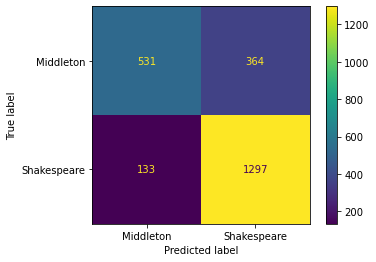

In [161]:
cmd.plot();
# plt.savefig("./Graphs/confusion_matrix.png", transparent=True);

## Visualizations

#### Timon of Athens

In [162]:
# Vectorize Timon of Athens text
timon_vec = tfidf_baseline.transform(timon["Line"])

In [163]:
# Find line-by-line rolling mean of Timon of Athen's predicted probability
timon_probs = list(final_model.predict_proba(timon_vec))
timon_probs_s = []
for pair in timon_probs:
    timon_probs_s.append(pair[1]*100)
timon_probs_s_series = pd.Series(timon_probs_s)
rolmean_timon = timon_probs_s_series.rolling(window=25).mean()

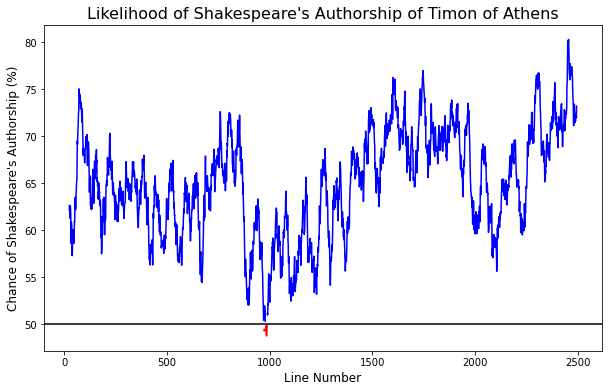

In [164]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.where(rolmean_timon > 50, rolmean_timon, None), color="blue", label="1")
plt.plot(np.where(rolmean_timon < 50, rolmean_timon, None), color="red", label="2")
plt.axhline(y=50, color="black")
plt.ylabel("Chance of Shakespeare's Authorship (%)", size=12)
plt.xlabel("Line Number", size=12)
plt.title("Likelihood of Shakespeare's Authorship of Timon of Athens", size=16);
# plt.savefig("./Graphs/timon.png", transparent=True, dpi=600);

### Training Set Plays

#### Othello

In [165]:
# Vectorize text of Othello
othello_vec = tfidf_baseline.transform(othello["Line"])

In [166]:
# Find line-by-line rolling mean of Othello's predicted probability
othello_probs = list(final_model.predict_proba(othello_vec))
othello_probs_s = []
for pair in othello_probs:
    othello_probs_s.append(pair[1]*100)
othello_probs_s_series = pd.Series(othello_probs_s)
rolmean_othello = othello_probs_s_series.rolling(window=25).mean()

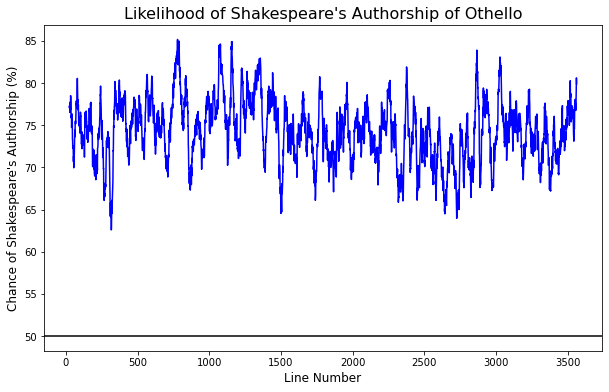

In [167]:
fig = plt.figure(figsize=(10, 6))
plt.plot(rolmean_othello, color='blue')
plt.axhline(y=50, color="black")
plt.ylabel("Chance of Shakespeare's Authorship (%)", size=12)
plt.xlabel("Line Number", size=12)
plt.title("Likelihood of Shakespeare's Authorship of Othello", size=16);
# plt.savefig("./Graphs/othello.png", transparent=True, dpi=600);

In [168]:
# Vectorize text of King Lear
lear_vec = tfidf_baseline.transform(king_lear["Line"])

In [169]:
# Find line-by-line rolling mean of King Lear's predicted probability
lear_probs = list(final_model.predict_proba(lear_vec))
lear_probs_s = []
for pair in lear_probs:
    lear_probs_s.append(pair[1]*100)
lear_probs_s_series = pd.Series(lear_probs_s)
rolmean_lear = lear_probs_s_series.rolling(window=25).mean()

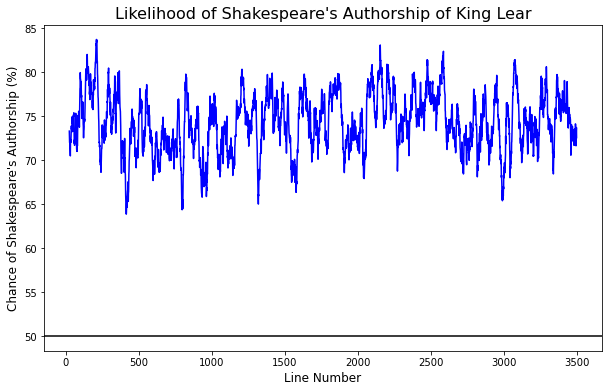

In [170]:
fig = plt.figure(figsize=(10, 6))
plt.plot(rolmean_lear, color='blue')
plt.axhline(y=50, color="black")
plt.ylabel("Chance of Shakespeare's Authorship (%)", size=12)
plt.xlabel("Line Number", size=12)
plt.title("Likelihood of Shakespeare's Authorship of King Lear", size=16);
# plt.savefig("./Graphs/lear.png", transparent=True, dpi=600);

In [171]:
# Vectorize text of Antony and Cleopatra
ac_vec = tfidf_baseline.transform(antony_and_cleopatra["Line"])

In [172]:
# Find line-by-line rolling mean of Antony and Cleopatra's predicted probability
ac_probs = list(final_model.predict_proba(ac_vec))
ac_probs_s = []
for pair in ac_probs:
    ac_probs_s.append(pair[1]*100)
ac_probs_s_series = pd.Series(ac_probs_s)
rolmean_ac = ac_probs_s_series.rolling(window=25).mean()

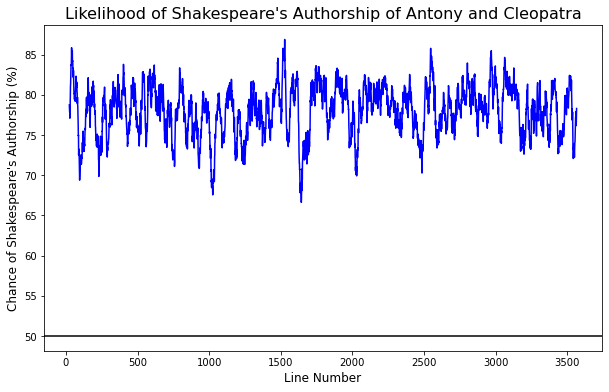

In [173]:
fig = plt.figure(figsize=(10, 6))
plt.plot(rolmean_ac, color='blue')
plt.axhline(y=50, color="black")
plt.ylabel("Chance of Shakespeare's Authorship (%)", size=12)
plt.xlabel("Line Number", size=12)
plt.title("Likelihood of Shakespeare's Authorship of Antony and Cleopatra", size=16);
# plt.savefig("./Graphs/antony_cleopatra.png", transparent=True, dpi=600);

In [174]:
# Vectorize text of Coriolanus
cor_vec = tfidf_baseline.transform(coriolanus["Line"])

In [175]:
# Find line-by-line rolling mean of Coriolanus' predicted probability
cor_probs = list(final_model.predict_proba(cor_vec))
cor_probs_s = []
for pair in cor_probs:
    cor_probs_s.append(pair[1]*100)
cor_probs_s_series = pd.Series(cor_probs_s)
rolmean_cor = cor_probs_s_series.rolling(window=25).mean()

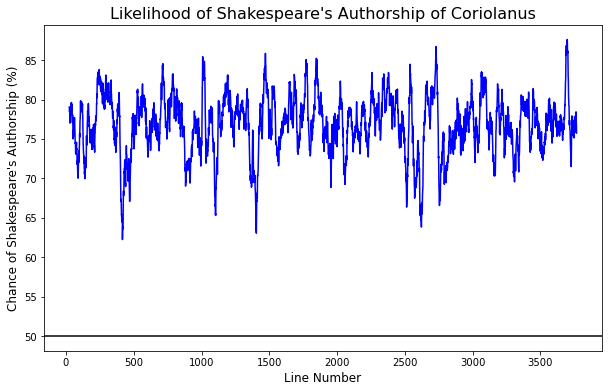

In [176]:
fig = plt.figure(figsize=(10, 6))
plt.plot(rolmean_cor, color='blue')
plt.axhline(y=50, color="black")
plt.ylabel("Chance of Shakespeare's Authorship (%)", size=12)
plt.xlabel("Line Number", size=12)
plt.title("Likelihood of Shakespeare's Authorship of Coriolanus", size=16);
# plt.savefig("./Graphs/coriolanus.png", transparent=True, dpi=600);

In [177]:
# Vectorize text of A Trick to Catch the Old One
trick_vec = tfidf_baseline.transform(trick["Line"])

In [178]:
# Find line-by-line rolling mean of A Trick to Catch the Old One's predicted probability
trick_probs = list(final_model.predict_proba(trick_vec))
trick_probs_s = []
for pair in trick_probs:
    trick_probs_s.append(pair[1]*100)
trick_probs_s_series = pd.Series(trick_probs_s)
rolmean_trick = trick_probs_s_series.rolling(window=25).mean()

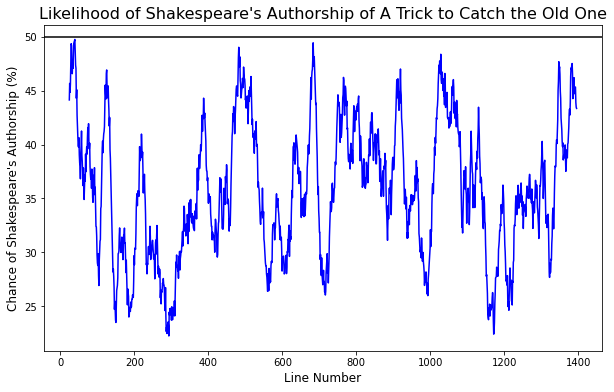

In [179]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.where(rolmean_trick > 50, rolmean_trick, None), color="red", label="1")
plt.plot(np.where(rolmean_trick < 50, rolmean_trick, None), color="blue", label="2")
plt.axhline(y=50, color="black")
plt.ylabel("Chance of Shakespeare's Authorship (%)", size=12)
plt.xlabel("Line Number", size=12)
plt.title("Likelihood of Shakespeare's Authorship of A Trick to Catch the Old One", size=16);
# plt.savefig("./Graphs/trick.png", transparent=True, dpi=600);

In [180]:
# Vectorize text of The Phoenix
phoenix_vec = tfidf_baseline.transform(phoenix["Line"])

In [181]:
# Find line-by-line rolling mean of The Phoenix's predicted probability
phoenix_probs = list(final_model.predict_proba(phoenix_vec))
phoenix_probs_s = []
for pair in phoenix_probs:
    phoenix_probs_s.append(pair[1]*100)
phoenix_probs_s_series = pd.Series(phoenix_probs_s)
rolmean_phoenix = phoenix_probs_s_series.rolling(window=25).mean()

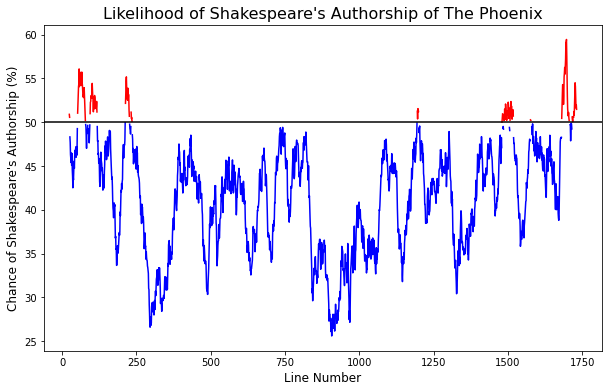

In [182]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.where(rolmean_phoenix > 50, rolmean_phoenix, None), color="red", label="1")
plt.plot(np.where(rolmean_phoenix < 50, rolmean_phoenix, None), color="blue", label="2")
plt.axhline(y=50, color="black")
plt.ylabel("Chance of Shakespeare's Authorship (%)", size=12)
plt.xlabel("Line Number", size=12)
plt.title("Likelihood of Shakespeare's Authorship of The Phoenix", size=16);
# plt.savefig("./Graphs/phoenix.png", transparent=True, dpi=600);

In [183]:
# Vectorize text of The Puritan
puritan_vec = tfidf_baseline.transform(puritan["Line"])

In [184]:
# Find line-by-line rolling mean of The Puritan's predicted probability
puritan_probs = list(final_model.predict_proba(puritan_vec))
puritan_probs_s = []
for pair in puritan_probs:
    puritan_probs_s.append(pair[1]*100)
puritan_probs_s_series = pd.Series(puritan_probs_s)
rolmean_puritan = puritan_probs_s_series.rolling(window=25).mean()

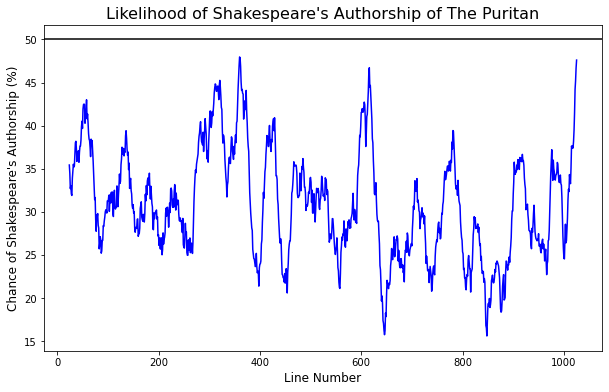

In [185]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.where(rolmean_puritan > 50, rolmean_puritan, None), color="red", label="1")
plt.plot(np.where(rolmean_puritan < 50, rolmean_puritan, None), color="blue", label="2")
plt.axhline(y=50, color="black")
plt.ylabel("Chance of Shakespeare's Authorship (%)", size=12)
plt.xlabel("Line Number", size=12)
plt.title("Likelihood of Shakespeare's Authorship of The Puritan", size=16);
# plt.savefig("./Graphs/puritan.png", transparent=True, dpi=600);

In [186]:
# Vectorize text of The Revenger's Tragedy
revengers_vec = tfidf_baseline.transform(revengers["Line"])

In [187]:
# Find line-by-line rolling mean of The Revenger's Tragedy's predicted probability
revengers_probs = list(final_model.predict_proba(revengers_vec))
revengers_probs_s = []
for pair in revengers_probs:
    revengers_probs_s.append(pair[1]*100)
revengers_probs_s_series = pd.Series(revengers_probs_s)
rolmean_revengers = revengers_probs_s_series.rolling(window=25).mean()

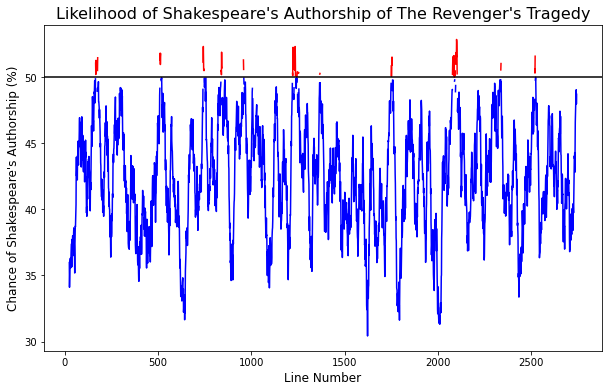

In [188]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.where(rolmean_revengers > 50, rolmean_revengers, None), color="red", label="1")
plt.plot(np.where(rolmean_revengers < 50, rolmean_revengers, None), color="blue", label="2")
plt.axhline(y=50, color="black")
plt.ylabel("Chance of Shakespeare's Authorship (%)", size=12)
plt.xlabel("Line Number", size=12)
plt.title("Likelihood of Shakespeare's Authorship of The Revenger's Tragedy", size=16);
# plt.savefig("./Graphs/revengers.png", transparent=True, dpi=600);

In [189]:
# Vectorize text of Your Five Gallants
gallants_vec = tfidf_baseline.transform(gallants["Line"])

In [190]:
# Find line-by-line rolling mean of Your Five Gallant's predicted probability
gallants_probs = list(final_model.predict_proba(gallants_vec))
gallants_probs_s = []
for pair in gallants_probs:
    gallants_probs_s.append(pair[1]*100)
gallants_probs_s_series = pd.Series(gallants_probs_s)
rolmean_gallants = gallants_probs_s_series.rolling(window=25).mean()

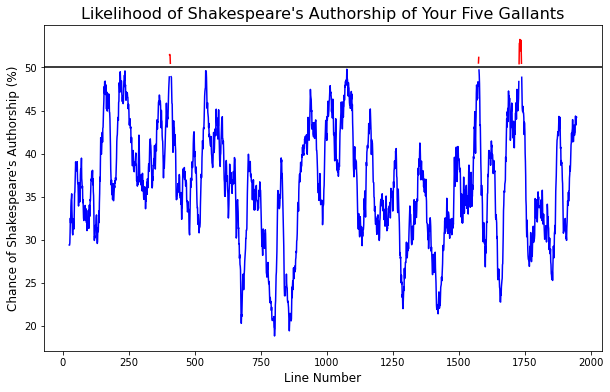

In [191]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.where(rolmean_gallants > 50, rolmean_gallants, None), color="red", label="1")
plt.plot(np.where(rolmean_gallants < 50, rolmean_gallants, None), color="blue", label="2")
plt.axhline(y=50, color="black")
plt.ylabel("Chance of Shakespeare's Authorship (%)", size=12)
plt.xlabel("Line Number", size=12)
plt.title("Likelihood of Shakespeare's Authorship of Your Five Gallants", size=16);
# plt.savefig("./Graphs/gallants.png", transparent=True, dpi=600);

## Test on Unseen Data: Pericles, Prince of Tyre

In [192]:
# Separate text of Pericles, Prince of Tyre
pericles = full_ws_df.loc[full_ws_df["Play"] == "Pericles"]

In [193]:
# Vectorize text of Pericles, Prince of Tyre
pericles_vec = tfidf_baseline.transform(pericles["Line"])

In [194]:
# Find line-by-line rolling mean of Pericles, Prince of Tyre's predicted probability
pericles_probs = list(final_model.predict_proba(pericles_vec))
pericles_probs_s = []
for pair in pericles_probs:
    pericles_probs_s.append(pair[1]*100)
pericles_probs_s_series = pd.Series(pericles_probs_s)
rolmean_pericles = pericles_probs_s_series.rolling(window=25).mean()

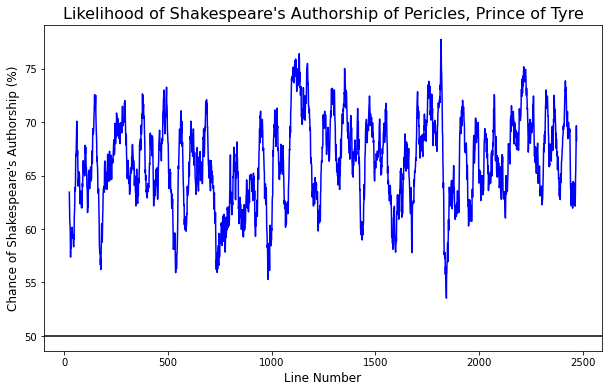

In [195]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.where(rolmean_pericles > 50, rolmean_pericles, None), color="blue", label="1")
plt.plot(np.where(rolmean_pericles < 50, rolmean_pericles, None), color="red", label="2")
plt.axhline(y=50, color="black")
plt.ylabel("Chance of Shakespeare's Authorship (%)", size=12)
plt.xlabel("Line Number", size=12)
plt.title("Likelihood of Shakespeare's Authorship of Pericles, Prince of Tyre", size=16);
# plt.savefig("./Graphs/Pericles.png", transparent=True, dpi=600);

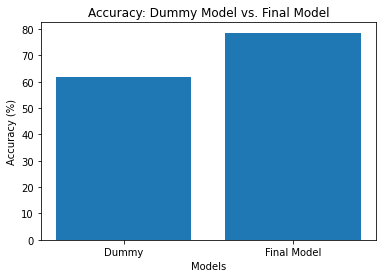

In [196]:
# Compare accuracy of dummy classifier and final model
models=["Dummy", "Final Model"]
accs=[dummy_score*100, fin_acc*100]
fig, ax = plt.subplots()
ax.bar(models, accs)
plt.title("Accuracy: Dummy Model vs. Final Model")
plt.ylabel("Accuracy (%)")
plt.xlabel("Models");
# plt.savefig("./Graphs/model_accuracy.png", transparent=True, dpi=600);